In [11]:
import torch
import torch.nn          as nn
import pandas            as pd
import numpy             as np
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from model            import custom_model
from dataset          import custom_dataset
from tqdm             import tqdm
from sklearn.metrics  import confusion_matrix


In [2]:
device = torch.device('cuda:0')

In [3]:
seq_len  = 100
n_sample = 10
train_dataset    = custom_dataset(seq_len, n_sample)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

530
0 399
100 399
200 399
300 399


In [4]:
iw        = train_dataset.X.shape[1]
n_feat    = 6
_input    = {'d_model': 128 , 'dropout': 0.1, 
             'n_layer':6 , 'iw':iw, 'nhead':8, 'n_class':4, 'n_feat': n_feat}
lr        = 1e-4
obj_model = custom_model(**_input).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(obj_model.parameters(), lr=lr)
losses    = []

In [5]:
epoch = 2000 - 500

obj_model.train()
progress = tqdm(range(epoch))

for i in progress:
    batch_loss = 0
    
    for (_in, _tgt) in train_dataloader:
        optimizer.zero_grad()
        _in  = _in.to(device)
        _tgt = _tgt.to(device)
        _out = obj_model(_in)        
        loss = criterion(_out, _tgt)
        loss.backward()
        optimizer.step()
        batch_loss += loss.cpu().detach()
    _loss = batch_loss / len(train_dataloader)
    losses.append(_loss)
        
    progress.set_description("{:0.5f}".format(_loss))


0.00012: 100%|██████████| 1500/1500 [09:35<00:00,  2.61it/s]


In [6]:
def get_acc():
    obj_model.eval()
    with torch.no_grad():
        _in  = torch.FloatTensor(train_dataset.X_test).to(device)
        _out = obj_model(_in)
        acc  = 0
        
        _, predicted = torch.max(_out, 1)
        
        cm = np.zeros((4,4))

        for (i_r, i_y) in zip(predicted, torch.LongTensor(train_dataset.Y_test).to(device)):
            cm[i_r, i_y] += 1
            if torch.all(i_r == i_y):
                acc += 1
                
        cm = cm / np.sum(cm, axis=1)[:,np.newaxis]
    return acc / len(_in), cm
            

In [7]:
acc, cm = get_acc()
print(acc)

0.9831460674157303


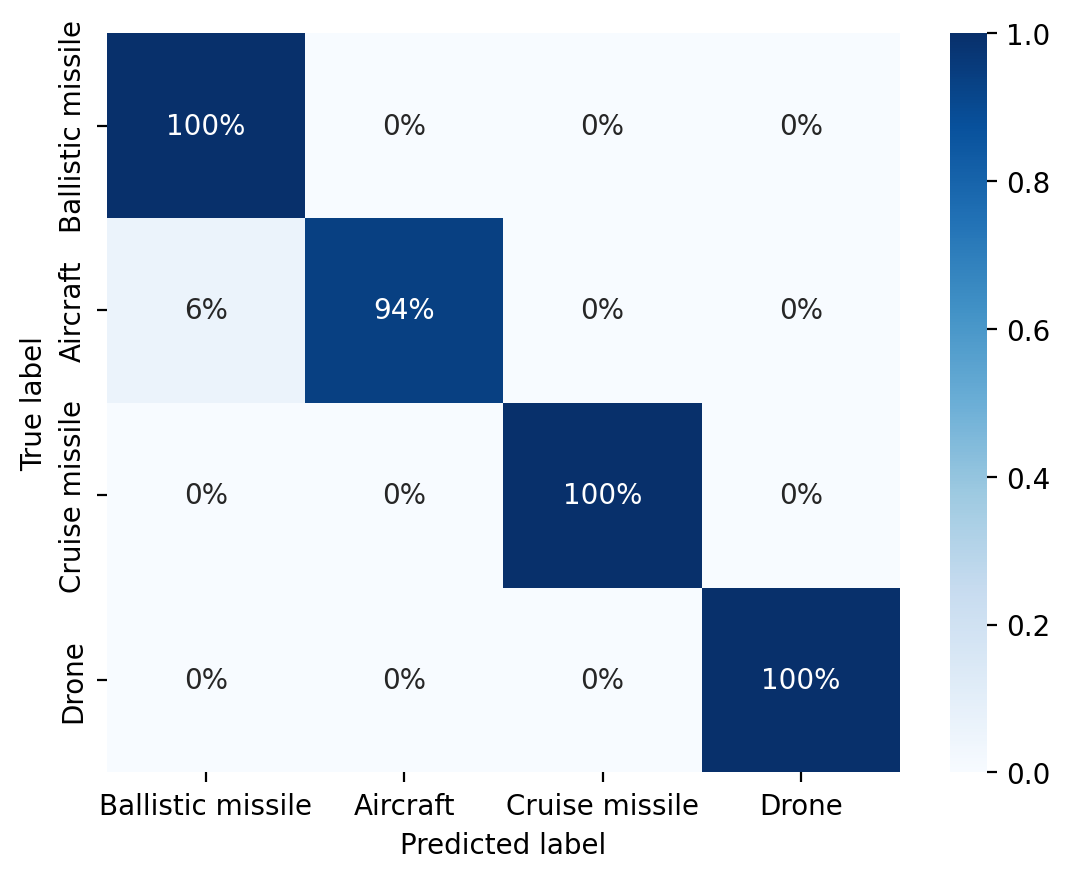

In [13]:

_class = ['Ballistic missile', 'Aircraft', 'Cruise missile', 'Drone']
labes  = np.tile(np.asarray(['Ballistic missile', 'Aircraft', 'Cruise missile', 'Drone']), (4, 1))
labels = np.array(_class)

plt.figure(dpi=200)
sns.heatmap(cm, annot=True , fmt='.0%',  cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()